In [1]:
import sys, os, platform, inspect

def get_current_file_path():
    # script filename (usually with path)
    filename = inspect.getfile(inspect.currentframe())
    # script directory
    path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    return filename, path


if platform.system() == 'Linux': # Colab setting
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/Colab Notebooks/kaggle'
else:
    _, path = get_current_file_path()    

sys.path.insert(0, path)
os.chdir(path)

sys.path.append(path + '/t-SNE')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
train = pd.read_csv('train.csv').to_numpy()

tr_train = torchvision.transforms.Compose([
    Image.fromarray,
    transforms.RandomRotation(10),    
    transforms.ToTensor(),
#        transforms.RandomErasing(p=0.2, scale=(0.02, .1)),        
    transforms.Normalize([0.5], [0.5],)
])
X_train, y_train = train[:, 1:], train[:, 0]
X_train, y_train = torch.tensor(X_train).to(torch.float).reshape(-1, 28, 28),\
                   torch.tensor(y_train)

X_train = torch.stack([
    tr_train(x.numpy().astype(np.uint8)) for x in torch.unbind(X_train, dim=0)
], dim=0)

dset_train = data.TensorDataset(X_train, y_train)

factor = 0.9
train_len = int(len(dset_train) * factor)
valid_len = len(dset_train)  - train_len

dset_train, dset_valid = data.random_split(dset_train, [train_len, valid_len])

batch_size = 16

dloader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_valid = data.DataLoader(dset_valid, batch_size=batch_size, shuffle=True)

tensor([0, 4, 7, 7, 0, 1, 6, 7, 2, 3, 9, 3, 6, 0, 4, 8])


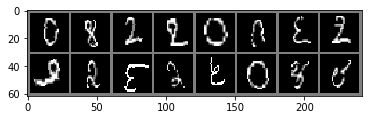

In [8]:
x, y = next(iter(dloader_train))
plt.imshow((torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

In [9]:
def conv2d_layer(c_in, c_out, k=3, padding=1, bn=True, relu=nn.ReLU()):
    seq = [nn.Conv2d(c_in, c_out, k, padding=padding), relu]
    if bn:
        seq.append(nn.BatchNorm2d(c_out))
    return(nn.Sequential(*seq))

class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16),
            conv2d_layer(16, 32),   nn.MaxPool2d(2),
            conv2d_layer(32, 64),
            conv2d_layer(64, 128),  nn.MaxPool2d(2),
            conv2d_layer(128, 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 128),
            nn.LeakyReLU(), nn.Dropout(),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [10]:
def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

In [12]:
model = Model()
model

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPool2d(kernel_size=

In [ ]:
@static_vars(ℓ_min=np.inf)
def save_model(ℓ, model, verbose=True):
    if ℓ < save_model.ℓ_min:
        save_model.ℓ_min = ℓ
        if verbose:
        #    print(f'min loss: {save_model.ℓ_min:.5f} current loss {ℓ:.5f}', end='')            
            print(f' ==> saving model')
        torch.save(model.state_dict(), 'model.pt')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
print(model)
ℓ_fn = nn.CrossEntropyLoss()
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 50
for i_epoch in range(1, epochs+1):
    for x, y in dloader_train:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        ℓ_fn(model(x), y).backward()
        optimizer.step()
    model.eval()
    loss_val = []
    loss_acc = []
    for x, y in dloader_train:
        x, y = x.to(device), y.to(device)
        ŷ = model(x)
        ℓ = ℓ_fn(ŷ, y)
        loss_val.append(ℓ.cpu().item())
        loss_acc.append((y == ŷ.argmax(dim=1)).to(torch.float).mean())
    model.train()
    print(f'Epoch {i_epoch} loss: {sum(loss_val)/len(loss_val):.5f}, accuracy: {sum(loss_acc)/len(loss_acc):.5f}')
    save_model(sum(loss_val)/len(loss_val), model)